In [43]:
import numpy as np
import cvxpy as cp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas_datareader as pdr
import math

#List of Holdings in Cannabis ETF
stocks = ['GWPH','CRON.TO','WEED.TO','CRBP','TLRY','APHA.TO','ACB.TO','OGI.TO',
          'SWMA.ST','SMG','TPB','MEDIF','ARNA','JAPAY','CARA','UVV','IMBBY','PM','BTI','SWM',
          'XXII','MO','VGR','HEXO','VFF','ZYNE','SNDL','TGODF','SPRWF','CNPOF','CBWTF',
          'VLNCF','PCLO.V','FLWPF','EMHTF']

MJ = 'MJ'


In [54]:
#Split training data and val data
#The two timer periods to divid
#Assuming COVID-19 is the start of 2020

pricesTraining = pdr.get_data_yahoo(stocks, start="2015-12-03", end="2019-12-31")[['Adj Close']]
etf_MJTraining = pdr.get_data_yahoo(MJ, start="2015-12-03", end="2019-12-31")[['Adj Close']]

pricesVal = pdr.get_data_yahoo(stocks, start="2020-01-01", end="2020-05-07")[['Adj Close']]
etf_MJVal = pdr.get_data_yahoo(MJ, start="2020-01-01", end="2020-05-07")[['Adj Close']]


In [86]:
etf_MJTotal = pdr.get_data_yahoo(MJ, start="2015-12-03", end="2020-05-07")[['Adj Close']]

In [77]:
#Interpolate data because not all stocks are traded in NYSE, so NaN for certain public holidays
pricesTraining = pricesTraining.interpolate(method = 'linear',limit_direction='forward')
pricesTraining = pricesTraining.interpolate(method = 'linear',limit_direction='backward')
pricesTraining.isnull().values.any()

False

In [78]:
# df.isnull().values.any()
pricesVal = pricesVal.interpolate(method = 'linear',limit_direction='forward')
pricesVal = pricesVal.interpolate(method = 'linear',limit_direction='backward')
pricesVal.isnull().values.any()

False

In [87]:
pricesTrainingReturns = pricesTraining.apply(np.log).apply(np.diff)
etf_MJTrainingReturns = etf_MJTraining.apply(np.log).apply(np.diff) 
                                                                             
pricesValReturns = pricesVal.apply(np.log).apply(np.diff)
etf_MJValReturns = etf_MJVal.apply(np.log).apply(np.diff)

etf_MJTotalReturns = etf_MJTotal.apply(np.log).apply(np.diff)

In [95]:
def cumulativeRet(weights, ret):
    weightedReturns = (weights * ret)
    portRet = weightedReturns.sum(axis=1)
    cumulativeRet = (portRet + 1).cumprod()
    return cumulativeRet

cumulativeRet(1, etf_MJTotalReturns)

0       0.995312
1       0.995312
2       0.976031
3       0.976031
4       0.987651
          ...   
1108   -3.447601
1109   -3.564978
1110   -3.535020
1111   -3.511074
1112   -3.525958
Length: 1113, dtype: float64

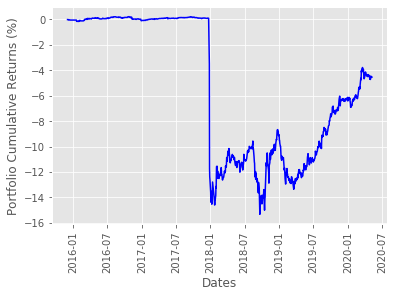

In [108]:
#Benchmark Returns
MJCumprod = np.cumprod(1 + etf_MJTotalReturns)-1

dates = list(etf_MJTotal.loc['2015-12-04':'2020-05-07'].index)


plt.xlabel("Dates")
plt.ylabel("Portfolio Cumulative Returns (%)")
plt.xticks(rotation=90)
plt.gca().ticklabel_format(useOffset=False, axis='both')
plt.plot(dates, list(MJCumprod['Adj Close']),'b')

In [109]:
#Methods for plotting efficient frontier using ajdusted close prices of stocks
#Portfolio Expected Return (lambda) y-axis
#Portfolio Volatility (lambda)      x-axis
def markowitz_Portfolio(lam,mu,sigma):
    n = np.shape(sigma)[0]
    w = cp.Variable(n)
    prob = cp.Problem(cp.Minimize(cp.quad_form(w, sigma) - lam * mu.T @ w),
                     [w >= np.zeros(n),
                     cp.sum(w) == 1])
    solve = prob.solve()
    return w.value

def Portfolio_Expected_Return(lam,mu,sigma):
    w = markowitz_Portfolio(lam,mu,sigma)
    expectedReturn = np.dot(w,mu)
    return expectedReturn

def Portfolio_Volatility(lam,mu,sigma):
    w = markowitz_Portfolio(lam,mu,sigma)
    vol = np.sqrt(w.T @ sigma @ w)
    return vol

In [718]:
#Methods for different types of Portfolios
# Uniform (1/N)
# Global Minimum Variance Portfolio (GMVP)
# Maximum Expected Return Portfolio (MRP)
# Maximum Sharpe Ratio Portfolio (MSRP)
# Most Diversified Portfolio (MDP)
# Inverse Volatility Portfolio (IVP)

#Uniform (1/N) Portfolio
def EWP(N):
    return np.ones(N)/N

#Global minimum variance portfolio (GMVP)
def GMVP(sigma,mu):
    w = cp.Variable(len(mu))
    var = cp.quad_form(w,sigma)
    problem = cp.Problem(cp.Minimize(var), [w >= 0, cp.sum(w) == 1])
    problem.solve()
    return w.value

#Maximum Sharpe Ratio Portfolio (MSRP) Using Schaible
def MSRP(sigma,mu):
    w = cp.Variable(len(mu))
    var = cp.quad_form(w,sigma)
    problem = cp.Problem(cp.Minimize(var), [w >= 0 , cp.sum(w * mu) == 1])
    problem.solve()
    quo = w.value/np.sum(w.value)
    return quo


#Inverse volatility portfolio (IVP)
def IVP(sigma):
    varSigma = np.sqrt(np.diag(sigma))
    w = 1/varSigma
    w = w/np.sum(w)
    return w

#Maximum expected return portfolio (MRP)
def MRP(mu):
    w = cp.Variable(len(mu))
    prob = cp.Problem(cp.Maximize(w.T @ mu), [w >= np.zeros(len(mu)),cp.sum(w) == 1])
    _ = prob.solve()
    return w.value

def cumulativeRet(weights, ret):
    weightedReturns = (weights * ret)
    portRet = weightedReturns.sum(axis=1)
    cumulativeRet = (portRet + 1).cumprod()
    return cumulativeRet

#N_stocks: Number of Stocks
def cumReturns(N_stocks, trainCVM, trainMu,logReturnsTest):
    w_EWP = EWP(N_stocks)
    w_GMVP = GMVP(trainCVM,trainMu)
    w_MSRP = MSRP(trainCVM,trainMu)
    w_MDP = MSRP(trainCVM,np.sqrt(np.diag(trainCVM))) #Most diversified portfolio (MDP)
    w_IVP = IVP(trainCVM)
    w_MRP = MRP(trainMu)

    EWP_Ret = cumulativeRet(w_EWP,logReturnsTest)
    GMVP_Ret = cumulativeRet(w_GMVP,logReturnsTest)
    MSRP_Ret = cumulativeRet(w_MSRP,logReturnsTest)
    MDP_Ret = cumulativeRet(w_MDP,logReturnsTest)
    IVP_Ret = cumulativeRet(w_IVP,logReturnsTest)
    MRP_Ret = cumulativeRet(w_MRP,logReturnsTest)
    return EWP_Ret,GMVP_Ret,MSRP_Ret, MDP_Ret, IVP_Ret, MRP_Ret

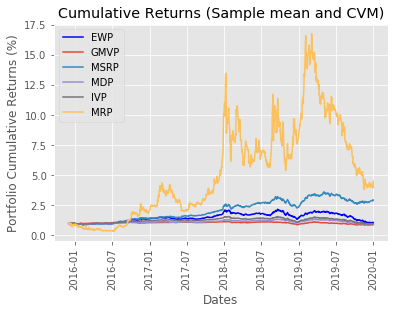

In [168]:
#Dollar Allocation 
trainCVM = np.cov(pricesTrainingReturns.T)
trainMu = np.mean(pricesTrainingReturns).to_numpy()
N_stocks = len(stocks)

#Dates start from 2019-01-01 as that is the first day of compounding
# pricesTraining = pdr.get_data_yahoo(stocks, start="2015-12-03", end="2019-12-31")[['Adj Close']]
# etf_MJVal = pdr.get_data_yahoo(MJ, start="2020-01-01", end="2020-05-07")[['Adj Close']]

dates = list(pricesTraining.loc['2015-12-03':'2019-12-31'].index)
#Reminder: logReturnsTest = prices.loc['2018-12-31':'2020-03-30'].apply(np.log).apply(np.diff)
EWP_Ret,GMVP_Ret,MSRP_Ret, MDP_Ret, IVP_Ret,MRP_Ret = cumReturns(N_stocks,
                                                                trainCVM,
                                                                trainMu,
                                                                pricesTrainingReturns)

EWP_Ret  =EWP_Ret
GMVP_Ret =GMVP_Ret 
MSRP_Ret =MSRP_Ret
MDP_Ret  =MDP_Ret
IVP_Ret  =IVP_Ret
MRP_Ret  =MRP_Ret

plt.xlabel("Dates")
plt.ylabel("Portfolio Cumulative Returns (%)")
plt.xticks(rotation=90)
plt.gca().ticklabel_format(useOffset=False, axis='both')
plt.plot(dates, list(EWP_Ret),'b',label='EWP')
plt.plot(dates, list(GMVP_Ret),label='GMVP')
plt.plot(dates, list(MSRP_Ret),label='MSRP')
plt.plot(dates, list(MDP_Ret),label='MDP')
plt.plot(dates, list(IVP_Ret),label='IVP')
plt.plot(dates, list(MRP_Ret),label='MRP')
plt.title("Cumulative Returns (Sample mean and CVM)")
plt.legend(loc='best')
plt.show()

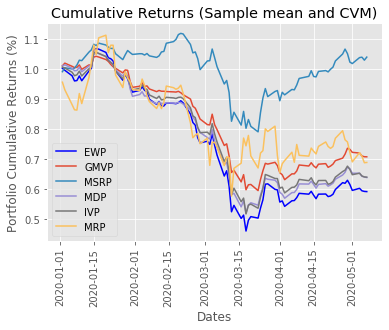

In [669]:
#Dollar Allocation 
trainCVM = np.cov(pricesTrainingReturns.T)
trainMu = np.mean(pricesTrainingReturns).to_numpy()
N_stocks = len(stocks)

#Dates start from 2019-01-01 as that is the first day of compounding
# pricesTraining = pdr.get_data_yahoo(stocks, start="2015-12-03", end="2019-12-31")[['Adj Close']]
# etf_MJVal = pdr.get_data_yahoo(MJ, start="2020-01-01", end="2020-05-07")[['Adj Close']]

dates = list(pricesVal.loc['2020-01-01':'2020-05-07'].index)
#Reminder: logReturnsTest = prices.loc['2018-12-31':'2020-03-30'].apply(np.log).apply(np.diff)
EWP_Ret,GMVP_Ret,MSRP_Ret, MDP_Ret, IVP_Ret,MRP_Ret = cumReturns(N_stocks,
                                                                trainCVM,
                                                                trainMu,
                                                                pricesValReturns)

EWP_Ret  =EWP_Ret
GMVP_Ret =GMVP_Ret 
MSRP_Ret =MSRP_Ret
MDP_Ret  =MDP_Ret
IVP_Ret  =IVP_Ret
MRP_Ret  =MRP_Ret

plt.xlabel("Dates")
plt.ylabel("Portfolio Cumulative Returns (%)")
plt.xticks(rotation=90)
plt.gca().ticklabel_format(useOffset=False, axis='both')
plt.plot(dates, list(EWP_Ret),'b',label='EWP')
plt.plot(dates, list(GMVP_Ret),label='GMVP')
plt.plot(dates, list(MSRP_Ret),label='MSRP')
plt.plot(dates, list(MDP_Ret),label='MDP')
plt.plot(dates, list(IVP_Ret),label='IVP')
plt.plot(dates, list(MRP_Ret),label='MRP')
plt.title("Cumulative Returns (Sample mean and CVM)")
plt.legend(loc='best')
plt.show()

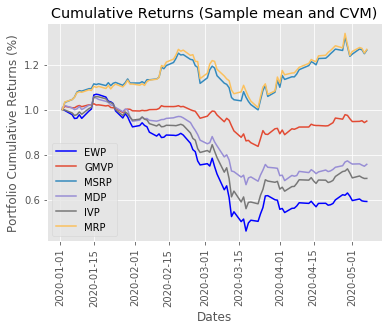

In [670]:
#Alternative Approach, get weights from corona aand apply to previous data

#Dollar Allocation 
trainCVM = np.cov(pricesValReturns.T)
trainMu = np.mean(pricesValReturns).to_numpy()
N_stocks = len(stocks)

#Dates start from 2019-01-01 as that is the first day of compounding
# pricesTraining = pdr.get_data_yahoo(stocks, start="2015-12-03", end="2019-12-31")[['Adj Close']]
# etf_MJVal = pdr.get_data_yahoo(MJ, start="2020-01-01", end="2020-05-07")[['Adj Close']]

dates = list(pricesVal.loc['2020-01-01':'2020-05-07'].index)
#Reminder: logReturnsTest = prices.loc['2018-12-31':'2020-03-30'].apply(np.log).apply(np.diff)
EWP_Ret,GMVP_Ret,MSRP_Ret, MDP_Ret, IVP_Ret,MRP_Ret = cumReturns(N_stocks,
                                                                trainCVM,
                                                                trainMu,
                                                                pricesValReturns)

EWP_Ret  =EWP_Ret
GMVP_Ret =GMVP_Ret 
MSRP_Ret =MSRP_Ret
MDP_Ret  =MDP_Ret
IVP_Ret  =IVP_Ret
MRP_Ret  =MRP_Ret

plt.xlabel("Dates")
plt.ylabel("Portfolio Cumulative Returns (%)")
plt.xticks(rotation=90)
plt.gca().ticklabel_format(useOffset=False, axis='both')
plt.plot(dates, list(EWP_Ret),'b',label='EWP')
plt.plot(dates, list(GMVP_Ret),label='GMVP')
plt.plot(dates, list(MSRP_Ret),label='MSRP')
plt.plot(dates, list(MDP_Ret),label='MDP')
plt.plot(dates, list(IVP_Ret),label='IVP')
plt.plot(dates, list(MRP_Ret),label='MRP')
plt.title("Cumulative Returns (Sample mean and CVM)")
plt.legend(loc='best')
plt.show()


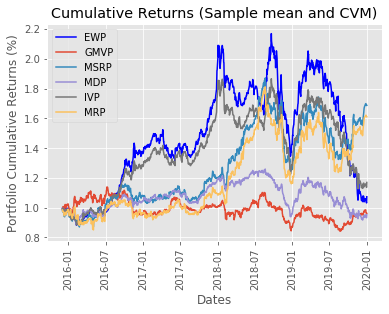

In [671]:
#Alternative Approach, get weights from corona aand apply to previous data

#Dollar Allocation 
trainCVM = np.cov(pricesValReturns.T)
trainMu = np.mean(pricesValReturns).to_numpy()
N_stocks = len(stocks)

#Dates start from 2019-01-01 as that is the first day of compounding
# pricesTraining = pdr.get_data_yahoo(stocks, start="2015-12-03", end="2019-12-31")[['Adj Close']]
# etf_MJVal = pdr.get_data_yahoo(MJ, start="2020-01-01", end="2020-05-07")[['Adj Close']]

dates = list(pricesTraining.loc['2015-12-03':'2019-12-31'].index)
#Reminder: logReturnsTest = prices.loc['2018-12-31':'2020-03-30'].apply(np.log).apply(np.diff)
EWP_Ret,GMVP_Ret,MSRP_Ret, MDP_Ret, IVP_Ret,MRP_Ret = cumReturns(N_stocks,
                                                                trainCVM,
                                                                trainMu,
                                                                pricesTrainingReturns)

EWP_Ret  =EWP_Ret
GMVP_Ret =GMVP_Ret 
MSRP_Ret =MSRP_Ret
MDP_Ret  =MDP_Ret
IVP_Ret  =IVP_Ret
MRP_Ret  =MRP_Ret

plt.xlabel("Dates")
plt.ylabel("Portfolio Cumulative Returns (%)")
plt.xticks(rotation=90)
plt.gca().ticklabel_format(useOffset=False, axis='both')
plt.plot(dates, list(EWP_Ret),'b',label='EWP')
plt.plot(dates, list(GMVP_Ret),label='GMVP')
plt.plot(dates, list(MSRP_Ret),label='MSRP')
plt.plot(dates, list(MDP_Ret),label='MDP')
plt.plot(dates, list(IVP_Ret),label='IVP')
plt.plot(dates, list(MRP_Ret),label='MRP')
plt.title("Cumulative Returns (Sample mean and CVM)")
plt.legend(loc='best')
plt.show()


In [215]:
def portfolioDR(X, lmd = 0.5, alpha = 2):
    T = len(X)
    mu = np.mean(X).to_numpy()
    w = cp.Variable(len(X.columns))
    X = X.to_numpy()
    prob = cp.Problem(cp.Maximize(w.T @ mu - (lmd/T) * cp.pnorm(mu.T @ w - X @ w,alpha)), [w >= 0, sum(w)==1])
    prob.solve()
    return w.value

portfolioDR(pricesTrainingReturns)

array([2.11542260e-10, 8.11326109e-01, 4.96437953e-10, 3.45415554e-10,
       1.72365585e-10, 3.89964441e-10, 2.04528629e-10, 3.18442819e-10,
       2.68112232e-10, 2.57494490e-10, 3.51197936e-10, 2.53391396e-10,
       2.77023387e-10, 1.83618139e-10, 2.00908617e-10, 2.25829684e-10,
       1.69734830e-10, 2.22444757e-10, 2.00624001e-10, 2.25039797e-10,
       1.82759070e-10, 2.10346163e-10, 2.06137971e-10, 1.34538322e-10,
       1.69625892e-10, 1.47878980e-10, 1.42712874e-10, 1.15170809e-10,
       3.14238517e-10, 1.12474166e-10, 9.29867639e-11, 1.88673884e-01,
       1.42658633e-10, 1.44042139e-10, 1.84706660e-10])

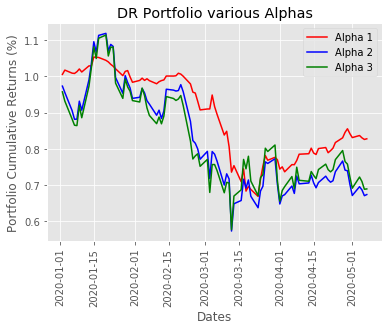

In [228]:
# portfolioDR not dependent on Variance
# Weights: portfolioDR(pricesTrainingReturns)
# Test Dataset: pricesValReturns
dr_alpha1 = cumulativeRet(portfolioDR(pricesTrainingReturns,alpha = 1),pricesValReturns)
dr_alpha2 = cumulativeRet(portfolioDR(pricesTrainingReturns,alpha = 2),pricesValReturns)
dr_alpha3 = cumulativeRet(portfolioDR(pricesTrainingReturns,alpha = 3),pricesValReturns)

dates = list(pricesVal.loc['2020-01-01':'2020-05-07'].index)

plt.xlabel("Dates")
plt.ylabel("Portfolio Cumulative Returns (%)")
plt.xticks(rotation=90)
plt.gca().ticklabel_format(useOffset=False, axis='both')
plt.plot(dates, list(dr_alpha1),'r',label='Alpha 1')
plt.plot(dates, list(dr_alpha2),'b',label='Alpha 2')
plt.plot(dates, list(dr_alpha3),'g',label='Alpha 3')

plt.title("DR Portfolio various Alphas")
plt.legend(loc='best')

In [241]:
# Mean CVar Poretfolio

def portfolioCVaR(X, lmd = 0.5, alpha = 0.95):
    T = len(X)
    mu = np.mean(X).to_numpy()
    
    #Variables
    w = cp.Variable(len(X.columns))
    z = cp.Variable(T)
    zeta = cp.Variable(1)
    
    X = X.to_numpy()

    prob = cp.Problem(cp.Maximize(w.T @ mu - lmd*zeta - (lmd/(T*(1-alpha))) * sum(z)),
                     [z >= 0, z >= -X @ w - zeta, w >= 0, sum(w) == 1])
    prob.solve()
    return w.value

In [242]:
portfolioCVaR(pricesTrainingReturns)

array([4.32441456e-02, 1.33799132e-02, 7.14963191e-15, 5.05541316e-15,
       2.77452053e-15, 2.40063637e-15, 2.03378569e-15, 2.52237477e-15,
       2.14414542e-01, 4.93988478e-02, 5.67432922e-03, 3.13469661e-02,
       9.92718902e-03, 2.29328660e-01, 4.44278381e-15, 9.00904628e-02,
       2.53579321e-02, 2.95520909e-02, 3.98684265e-15, 5.36700070e-02,
       1.30734202e-15, 3.17179108e-02, 6.23098525e-02, 3.83271086e-15,
       3.43965741e-02, 6.92728682e-16, 3.85696944e-02, 5.09078628e-16,
       1.03335427e-15, 2.03142003e-15, 1.62168131e-15, 1.02748188e-02,
       2.73460636e-02, 8.69191269e-15, 3.46319442e-16])

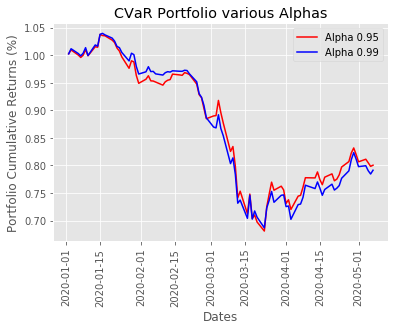

In [292]:
CVaR_a095 = cumulativeRet(portfolioCVaR(pricesTrainingReturns,alpha = 0.95),pricesValReturns)
CVaR_a099 = cumulativeRet(portfolioCVaR(pricesTrainingReturns,alpha = 0.99),pricesValReturns)
dates = list(pricesVal.loc['2020-01-01':'2020-05-07'].index)

plt.xlabel("Dates")
plt.ylabel("Portfolio Cumulative Returns (%)")
plt.xticks(rotation=90)
plt.gca().ticklabel_format(useOffset=False, axis='both')
plt.plot(dates, list(CVaR_a095),'r',label='Alpha 0.95')
plt.plot(dates, list(CVaR_a099),'b',label='Alpha 0.99')


plt.title("CVaR Portfolio various Alphas")
plt.legend(loc='best')


In [288]:
def portfolioMaxDD(X, c= 0.2):
    T = len(X)
    N = len(X.columns)
    mu = np.mean(X).to_numpy()
    X = X.to_numpy()
    
    dfCumsum = pd.DataFrame(columns = pricesTrainingReturns.columns)
    for n in pricesTrainingReturns.columns:
        dfCumsum[n] = pricesTrainingReturns[n].cumsum()
    X_cum = dfCumsum.iloc[-1].to_numpy()

    #Variables
    w = cp.Variable(N)
    u = cp.Variable(T)
    
    #Problem
    
    prob = cp.Problem(cp.Maximize(w.T @ mu),
                     [w >= 0, sum(w) == 1,
                     u <= X_cum @ w + c,
                     u >= X_cum @ w,
                     #u[-1] >= u[-T]
                     u[1:] >= u[:T-1]])
    prob.solve()
    return w.value

In [282]:
T = len(pricesTrainingReturns)
u = cp.Variable(T)
x = [0,1,2,3,4]
x[:4]

[0, 1, 2, 3]

In [289]:
portfolioMaxDD(pricesTrainingReturns)

array([3.68926300e-13, 1.00000000e+00, 1.71914437e-12, 2.99480217e-13,
       3.87168036e-13, 3.16845344e-13, 3.49578891e-13, 3.00989787e-13,
       3.40428971e-13, 3.44088789e-13, 2.99103025e-13, 3.41578778e-13,
       3.30935013e-13, 3.88408469e-13, 3.74098046e-13, 3.64307805e-13,
       3.95244974e-13, 3.66238559e-13, 3.78935373e-13, 3.64462157e-13,
       3.84223796e-13, 3.73487211e-13, 3.75988910e-13, 4.03836818e-13,
       3.93396394e-13, 4.00948714e-13, 4.04652796e-13, 3.98419723e-13,
       3.00297394e-13, 3.94093828e-13, 3.70044701e-13, 1.23244174e-12,
       4.04555684e-13, 4.04500637e-13, 3.65460648e-13])

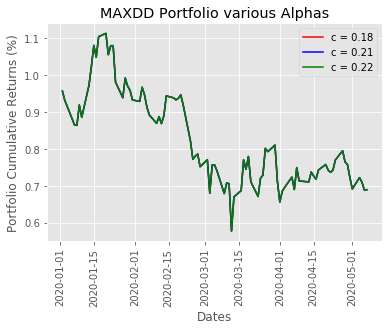

In [291]:
maxDD_c018 = cumulativeRet(portfolioMaxDD(pricesTrainingReturns, c = 0.18),pricesValReturns)
maxDD_c021 = cumulativeRet(portfolioMaxDD(pricesTrainingReturns, c = 0.21),pricesValReturns)
maxDD_c022 = cumulativeRet(portfolioMaxDD(pricesTrainingReturns, c = 0.22),pricesValReturns)

dates = list(pricesVal.loc['2020-01-01':'2020-05-07'].index)

plt.xlabel("Dates")
plt.ylabel("Portfolio Cumulative Returns (%)")
plt.xticks(rotation=90)
plt.gca().ticklabel_format(useOffset=False, axis='both')
plt.plot(dates, list(maxDD_c018),'r',label='c = 0.18')
plt.plot(dates, list(maxDD_c021),'b',label='c = 0.21')
plt.plot(dates, list(maxDD_c022),'g',label='c = 0.22')


plt.title("MAXDD Portfolio various Alphas")
plt.legend(loc='best')


In [298]:
maxDD_c018 = cumulativeRet(portfolioMaxDD(pricesTrainingReturns, c = 0.18),pricesValReturns)
maxDD_c018

0     0.956961
1     0.931576
2     0.882209
3     0.865039
4     0.864038
        ...   
85    0.691382
86    0.722229
87    0.709868
88    0.688544
89    0.689418
Length: 90, dtype: float64

In [307]:
#Mean - Ave - DD Portfolio
def portfolioAveDD(X, c = 0.2):
    T = len(X)
    N = len(X.columns)
    mu = np.mean(X).to_numpy()
    X = X.to_numpy()
    
    dfCumsum = pd.DataFrame(columns = pricesTrainingReturns.columns)
    for n in pricesTrainingReturns.columns:
        dfCumsum[n] = pricesTrainingReturns[n].cumsum()
    X_cum = dfCumsum.iloc[-1].to_numpy()

    #Variables
    w = cp.Variable(N)
    u = cp.Variable(T)
    
    prob = cp.Problem(cp.Maximize(w.T @ mu),
                     [w >= 0, sum(w) == 1,
                     np.mean(u) <= np.mean(X_cum @ w) + c,
                     u >= X_cum @ w,
#                      u[-1] >= u[-T]])
                     u[1:] >= u[:T-1]])
    prob.solve()
    return w.value

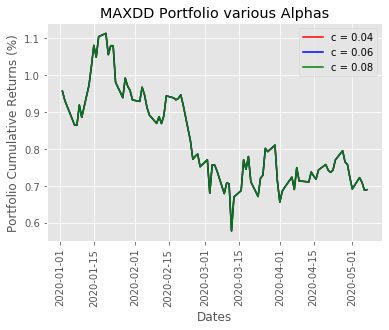

In [308]:
aveDD_c004 = cumulativeRet(portfolioAveDD(pricesTrainingReturns, c = 0.04),pricesValReturns)
aveDD_c006 = cumulativeRet(portfolioAveDD(pricesTrainingReturns, c = 0.06),pricesValReturns)
aveDD_c008 = cumulativeRet(portfolioAveDD(pricesTrainingReturns, c = 0.08),pricesValReturns)

dates = list(pricesVal.loc['2020-01-01':'2020-05-07'].index)

plt.xlabel("Dates")
plt.ylabel("Portfolio Cumulative Returns (%)")
plt.xticks(rotation=90)
plt.gca().ticklabel_format(useOffset=False, axis='both')
plt.plot(dates, list(aveDD_c004),'r',label='c = 0.04')
plt.plot(dates, list(aveDD_c006),'b',label='c = 0.06')
plt.plot(dates, list(aveDD_c008),'g',label='c = 0.08')


plt.title("MAXDD Portfolio various Alphas")
plt.legend(loc='best')

In [305]:
aveDD_c004 = cumulativeRet(portfolioAveDD(pricesTrainingReturns, c = 0.04),pricesValReturns)
rollMax = aveDD_c004.cummax()
daily_drawdown = aveDD_c004/rollMax - 1
Max_Daily_Drawdown = daily_drawdown.cummin()
Max_Daily_Drawdown

0     0.000000
1    -0.026527
2    -0.078114
3    -0.096056
4    -0.097101
        ...   
85   -0.481728
86   -0.481728
87   -0.481728
88   -0.481728
89   -0.481728
Length: 90, dtype: float64

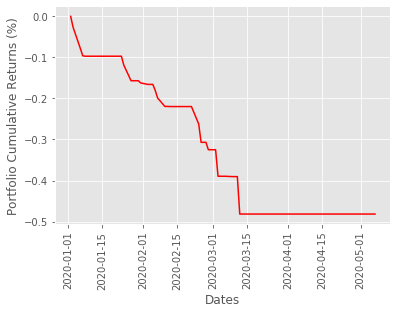

In [306]:
#Return Drawdown
def drawdown(r):
    rollMax = r.cummax()
    daily_drawdown = r/rollMax -1
    Max_Daily_Drawdown = daily_drawdown.cummin()
    return Max_Daily_Drawdown

dates = list(pricesVal.loc['2020-01-01':'2020-05-07'].index)

plt.xlabel("Dates")
plt.ylabel("Portfolio Cumulative Returns (%)")
plt.xticks(rotation=90)
plt.gca().ticklabel_format(useOffset=False, axis='both')
plt.plot(dates, list(drawdown(aveDD_c004)),'r',label='c = 0.18')

In [323]:
#Altnerative Portfolio
def meanCDar(X, c = 0.1, alpha = 0.95):
    T = len(X)
    N = len(X.columns)
    X = X.to_numpy()
    
    dfCumsum = pd.DataFrame(columns = pricesTrainingReturns.columns)
    for n in pricesTrainingReturns.columns:
        dfCumsum[n] = pricesTrainingReturns[n].cumsum()
    X_cum = dfCumsum.iloc[-1].to_numpy()
    
    mu = np.mean(X)
    
    #Variables
    w = cp.Variable(N)
    z = cp.Variable(T)
    zeta = cp.Variable(1)
    u = cp.Variable(T)
    
    #Problem
    prob = cp.Problem(cp.Maximize(w.T @ mu),
                     [w >= 0, sum(w) == 1,
                     zeta + (1/(T * (1-alpha))) * sum(z) <= c,
                     z >= 0, z >= u - X_cum @ w - zeta,
                     u >= X_cum @ w,
                     u[-1] >= u[-T]])
                      #u[1:] >= u[:T-1]])
    prob.solve()
    return w.value()


In [324]:
# np.mean(pricesTrainingReturns)
meanCDar(pricesTrainingReturns)

ValueError: Scalar operands are not allowed, use '*' instead

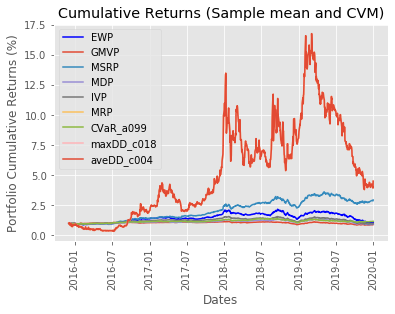

In [332]:
# Still Need to fix part above meanCDar
# In sample
trainCVM = np.cov(pricesTrainingReturns.T)
trainMu = np.mean(pricesTrainingReturns).to_numpy()
N_stocks = len(stocks)

#Dates start from 2019-01-01 as that is the first day of compounding
# pricesTraining = pdr.get_data_yahoo(stocks, start="2015-12-03", end="2019-12-31")[['Adj Close']]
# etf_MJVal = pdr.get_data_yahoo(MJ, start="2020-01-01", end="2020-05-07")[['Adj Close']]

dates = list(pricesTraining.loc['2015-12-03':'2019-12-31'].index)
#Reminder: logReturnsTest = prices.loc['2018-12-31':'2020-03-30'].apply(np.log).apply(np.diff)
EWP_Ret,GMVP_Ret,MSRP_Ret, MDP_Ret, IVP_Ret,MRP_Ret = cumReturns(N_stocks,
                                                                trainCVM,
                                                                trainMu,
                                                                pricesTrainingReturns)

EWP_Ret  =EWP_Ret
GMVP_Ret =GMVP_Ret 
MSRP_Ret =MSRP_Ret
MDP_Ret  =MDP_Ret
IVP_Ret  =IVP_Ret
MRP_Ret  =MRP_Ret

CVaR_a095 = cumulativeRet(portfolioCVaR(pricesTrainingReturns,alpha = 0.95),pricesTrainingReturns)
CVaR_a099 = cumulativeRet(portfolioCVaR(pricesTrainingReturns,alpha = 0.99),pricesTrainingReturns)

maxDD_c018 = cumulativeRet(portfolioMaxDD(pricesTrainingReturns, c = 0.18),pricesTrainingReturns)
maxDD_c021 = cumulativeRet(portfolioMaxDD(pricesTrainingReturns, c = 0.21),pricesTrainingReturns)
maxDD_c022 = cumulativeRet(portfolioMaxDD(pricesTrainingReturns, c = 0.22),pricesTrainingReturns)

aveDD_c004 = cumulativeRet(portfolioAveDD(pricesTrainingReturns, c = 0.04),pricesTrainingReturns)
aveDD_c006 = cumulativeRet(portfolioAveDD(pricesTrainingReturns, c = 0.06),pricesTrainingReturns)
aveDD_c008 = cumulativeRet(portfolioAveDD(pricesTrainingReturns, c = 0.08),pricesTrainingReturns)


plt.xlabel("Dates")
plt.ylabel("Portfolio Cumulative Returns (%)")
plt.xticks(rotation=90)
plt.gca().ticklabel_format(useOffset=False, axis='both')

plt.plot(dates, list(EWP_Ret),'b',label='EWP')
plt.plot(dates, list(GMVP_Ret),label='GMVP')
plt.plot(dates, list(MSRP_Ret),label='MSRP')
plt.plot(dates, list(MDP_Ret),label='MDP')
plt.plot(dates, list(IVP_Ret),label='IVP')
plt.plot(dates, list(MRP_Ret),label='MRP')

# plt.plot(dates, list(CVaR_a095),label='CVaR_a095')
plt.plot(dates, list(CVaR_a099),label='CVaR_a099')

plt.plot(dates, list(maxDD_c018),label='maxDD_c018')
# plt.plot(dates, list(maxDD_c021),label='maxDD_c021')
# plt.plot(dates, list(maxDD_c022),label='maxDD_c022')

plt.plot(dates, list(aveDD_c004),label='aveDD_c004')
# plt.plot(dates, list(aveDD_c006),label='aveDD_c006')
# plt.plot(dates, list(aveDD_c008),label='aveDD_c008')

plt.title("Cumulative Returns (Sample mean and CVM)")
plt.legend(loc='best')
plt.show()

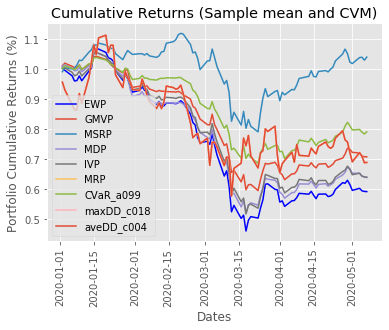

In [331]:
# Still Need to fix part above meanCDar
# Out of Sample
trainCVM = np.cov(pricesTrainingReturns.T)
trainMu = np.mean(pricesTrainingReturns).to_numpy()
N_stocks = len(stocks)

#Dates start from 2019-01-01 as that is the first day of compounding
# pricesTraining = pdr.get_data_yahoo(stocks, start="2015-12-03", end="2019-12-31")[['Adj Close']]
# etf_MJVal = pdr.get_data_yahoo(MJ, start="2020-01-01", end="2020-05-07")[['Adj Close']]

dates = list(pricesVal.loc['2020-01-01':'2020-05-07'].index)
#Reminder: logReturnsTest = prices.loc['2018-12-31':'2020-03-30'].apply(np.log).apply(np.diff)
EWP_Ret,GMVP_Ret,MSRP_Ret, MDP_Ret, IVP_Ret,MRP_Ret = cumReturns(N_stocks,
                                                                trainCVM,
                                                                trainMu,
                                                                pricesValReturns)

EWP_Ret  =EWP_Ret
GMVP_Ret =GMVP_Ret 
MSRP_Ret =MSRP_Ret
MDP_Ret  =MDP_Ret
IVP_Ret  =IVP_Ret
MRP_Ret  =MRP_Ret

CVaR_a095 = cumulativeRet(portfolioCVaR(pricesTrainingReturns,alpha = 0.95),pricesValReturns)
CVaR_a099 = cumulativeRet(portfolioCVaR(pricesTrainingReturns,alpha = 0.99),pricesValReturns)

maxDD_c018 = cumulativeRet(portfolioMaxDD(pricesTrainingReturns, c = 0.18),pricesValReturns)
maxDD_c021 = cumulativeRet(portfolioMaxDD(pricesTrainingReturns, c = 0.21),pricesValReturns)
maxDD_c022 = cumulativeRet(portfolioMaxDD(pricesTrainingReturns, c = 0.22),pricesValReturns)

aveDD_c004 = cumulativeRet(portfolioAveDD(pricesTrainingReturns, c = 0.04),pricesValReturns)
aveDD_c006 = cumulativeRet(portfolioAveDD(pricesTrainingReturns, c = 0.06),pricesValReturns)
aveDD_c008 = cumulativeRet(portfolioAveDD(pricesTrainingReturns, c = 0.08),pricesValReturns)


plt.xlabel("Dates")
plt.ylabel("Portfolio Cumulative Returns (%)")
plt.xticks(rotation=90)
plt.gca().ticklabel_format(useOffset=False, axis='both')

plt.plot(dates, list(EWP_Ret),'b',label='EWP')
plt.plot(dates, list(GMVP_Ret),label='GMVP')
plt.plot(dates, list(MSRP_Ret),label='MSRP')
plt.plot(dates, list(MDP_Ret),label='MDP')
plt.plot(dates, list(IVP_Ret),label='IVP')
plt.plot(dates, list(MRP_Ret),label='MRP')

# plt.plot(dates, list(CVaR_a095),label='CVaR_a095')
plt.plot(dates, list(CVaR_a099),label='CVaR_a099')

plt.plot(dates, list(maxDD_c018),label='maxDD_c018')
# plt.plot(dates, list(maxDD_c021),label='maxDD_c021')
# plt.plot(dates, list(maxDD_c022),label='maxDD_c022')

plt.plot(dates, list(aveDD_c004),label='aveDD_c004')
# plt.plot(dates, list(aveDD_c006),label='aveDD_c006')
## plt.plot(dates, list(aveDD_c008),label='aveDD_c008')

plt.title("Cumulative Returns (Sample mean and CVM)")
plt.legend(loc='best')
plt.show()

In [531]:


#Robust Estimator Markowitz's mean-variance portfolio
def portfolioMaxSharpeRatio(mu, sigma):
    w = cp.Variable(len(mu))
    var = cp.quad_form(w,sigma)
    problem = cp.Problem(cp.Minimize(var), [w >= 0 , cp.sum(w * mu) == 1])
    problem.solve()
    quo = w.value/np.sum(w.value)
    return quo

def portfolioGMVPRobustBox(Sigma_lb, Sigma_ub):
    N = len(Sigma_lb)
    w = cp.Variable(N)
    lam_ub = cp.Variable(N,N)
    lam_lb = cp.Variable(N,N)
    prob = cp.Problem(cp.Minimize(t))



In [508]:
#T is the number of days
#Robust Optimization of Global Maximum Return Portfolio
trainMu = np.mean(pricesTrainingReturns).to_numpy()
trainCVM = np.cov(pricesTrainingReturns.T)


def portfolioMaxReturnRobustBox(mu_hat, delta):
    w = cp.Variable(len(mu_hat))
    prob = cp.Problem(cp.Maximize(w.T @ mu_hat -abs(w).T @ delta),
                     [w >= 0, sum(w) ==1])
    prob.solve()
    return w.value()
    
def portfolioMaxReturn(mu):
    w = cp.Variable(len(mu))
    prob = cp.Problem(cp.Maximize(w.T @ mu),
                     [w >= 0, sum(w) == 1])
    prob.solve()
    return w.value

def portfolioMaxReturnRobustEllipsoid(mu_hat, S, kappa = 0.1):
    S12 = np.linalg.cholesky(S)
    N = len(mu_hat)
    w = cp.Variable(N)
    var = S12 @ w
    prob = cp.Problem(cp.Maximize(w.T @ mu_hat - kappa * cp.norm(S12 @ w,2)),
                    [w >= 0, sum(w) == 1])
    prob.solve()
    return w.value


Expression(CONVEX, NONNEGATIVE, ())

In [437]:
def sigma_est(Sigma_scm,mu_sm):
    Sigma_T = np.diag(np.diag(Sigma_scm))
    T = len(Sigma_scm)
    W = np.eye(T) - np.ones(T*T).reshape((T, T))/T
    rho1_sweep = np.exp(np.linspace(-10, 10, 100))
    obj = []
    for rho1 in rho1_sweep:
        Sigma_sh = rho1 * Sigma_T + Sigma_scm
        D = (1/T)*np.sum(np.diag(Sigma_scm @ np.linalg.solve(Sigma_sh, np.eye(len(Sigma_sh)))))
        delta = D / (1 - D)
        B = np.linalg.solve((np.eye(T)+delta*W) @ (np.eye(T)+delta*W), np.eye(len(W)))
        b = T / np.sum(np.diag(W @ B))
        inv_S_sh_mu = np.linalg.solve(Sigma_sh, mu_sm).reshape((1, Sigma_sh.shape[0]))
        num = np.sum(mu_sm * inv_S_sh_mu) - delta
        den = np.sqrt(b * inv_S_sh_mu @ Sigma_scm @ inv_S_sh_mu.T)
        obj.append(num/den)
    i_max = np.argmax(obj)
    rho1 = rho1_sweep[i_max]
    rho_1 = (rho1/(1 + rho1))
    estSigma = (1-rho_1)*Sigma_scm + rho_1*Sigma_T
    return estSigma, rho_1

def mu_est(sigma,mu):
    T = len(sigma)
    t_1 = np.zeros(T)
    lambdas , _ = np.linalg.eig(sigma)
    lmd_max = np.max(lambdas)
    lmd_mean = np.mean(lambdas)
    rho_2 = (1/T)*(T*lmd_mean - 2*lmd_max)/np.linalg.norm(mu - t_1)**2
    estMu = rho_2 * mu + (1-rho_2) * np.sum(mu) * np.ones(T) / T
    return estMu,rho_2

def removeNeg(arr):
    for n in range(0, len(arr[0])):
        for j in range(0, len(arr[0][n])):
            if arr[0][n][j] < 0:
                arr[0][n][j] = 0
    return arr

sigmaEst= sigma_est(trainCVM,trainMu)
meanEst = mu_est(trainCVM,trainMu)

In [476]:
X_noisy = np.random.multivariate_normal(mu,sigma, size = 1052 )
# np.random.multivariate_normal(mu,sigma)
# len(dates)


array([-0.00203765,  0.05090159,  0.04152928,  0.01723071, -0.00711963,
        0.02325893,  0.00320426,  0.01866004,  0.00636697,  0.00474111,
        0.01457784,  0.00624858,  0.0094628 , -0.00713268, -0.00157123,
        0.00135797, -0.01126236,  0.00080452, -0.00325028,  0.00055463,
       -0.00747513, -0.0017787 , -0.00203999, -0.02235713, -0.00934408,
       -0.01915038, -0.02066154, -0.03225103,  0.01606014, -0.03338837,
       -0.04638102,  0.04309637, -0.02028684, -0.01861213,  0.00190585])

In [509]:
sigma = removeNeg(sigmaEst)[0]
mu = meanEst[0]

w_GMRP_robust_ellipsoid_noisy = []


kappa = 0.2
for i in range(1,6):
    X_noisy = np.random.multivariate_normal(mu,sigma, size = 1052)
    mu_noisy = np.mean(X_noisy, axis = 0)
    Sigma_noisy = np.cov(X_noisy.T)
    w_GMRP_robust_ellipsoid_noisy.append(portfolioMaxReturnRobustEllipsoid(mu_noisy, Sigma_noisy, kappa))

array([3.10476098e-12, 5.80486736e-01, 1.15655099e-01, 7.09986973e-12,
       2.45865178e-12, 1.04803533e-11, 3.50359843e-12, 7.23663996e-12,
       4.30101311e-12, 4.07576656e-12, 6.19611849e-12, 4.19138831e-12,
       4.64963710e-12, 2.33797329e-12, 2.95872720e-12, 3.21354054e-12,
       2.02546128e-12, 3.14058278e-12, 2.66514861e-12, 3.37317534e-12,
       2.41627748e-12, 2.90118405e-12, 2.82005696e-12, 1.26192248e-12,
       2.05340638e-12, 1.72039889e-12, 1.49020327e-12, 9.20133412e-13,
       6.36474152e-12, 7.84918194e-13, 2.28925242e-13, 3.03858164e-01,
       1.41829649e-12, 1.46732969e-12, 3.08564208e-12])

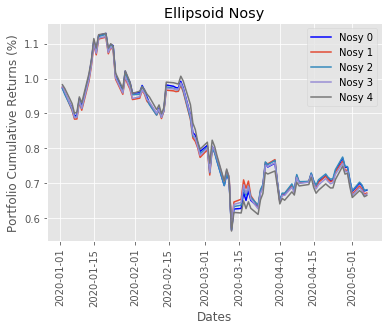

In [518]:
#All relatively close
ellipsoidNosy0 = cumulativeRet(w_GMRP_robust_ellipsoid_noisy[0],pricesValReturns)
ellipsoidNosy1 = cumulativeRet(w_GMRP_robust_ellipsoid_noisy[1],pricesValReturns)
ellipsoidNosy2 = cumulativeRet(w_GMRP_robust_ellipsoid_noisy[2],pricesValReturns)
ellipsoidNosy3 = cumulativeRet(w_GMRP_robust_ellipsoid_noisy[3],pricesValReturns)
ellipsoidNosy4 = cumulativeRet(w_GMRP_robust_ellipsoid_noisy[4],pricesValReturns)

dates = list(pricesVal.loc['2020-01-01':'2020-05-07'].index)

plt.xlabel("Dates")
plt.ylabel("Portfolio Cumulative Returns (%)")
plt.xticks(rotation=90)
plt.gca().ticklabel_format(useOffset=False, axis='both')

plt.plot(dates, list(ellipsoidNosy0),'b',label='Nosy 0')
plt.plot(dates, list(ellipsoidNosy1),label='Nosy 1')
plt.plot(dates, list(ellipsoidNosy2),label='Nosy 2')
plt.plot(dates, list(ellipsoidNosy3),label='Nosy 3')
plt.plot(dates, list(ellipsoidNosy4),label='Nosy 4')


plt.title("Ellipsoid Nosy")
plt.legend(loc='best')
plt.show()


In [490]:
a = np.arange(9) - 4
b = a.reshape((3, 3))
b
np.linalg.norm(b,ord =2)
b @ b

array([[15,  6, -3],
       [ 6,  6,  6],
       [-3,  6, 15]])

In [447]:
np.random.multivariate_normal(mu,sigma)

array([-0.0257353 ,  0.05024689,  0.02695285,  0.04864652, -0.04949742,
        0.0911496 , -0.02051902, -0.01158586,  0.02162169,  0.0554891 ,
       -0.03389109,  0.01649771, -0.02267285, -0.01533389,  0.044296  ,
        0.02027908,  0.01447242,  0.02451804, -0.00375228,  0.01553194,
        0.03905074, -0.00306341, -0.00633165, -0.00036704, -0.02808676,
        0.00953037,  0.01472012, -0.05017098,  0.04345893, -0.00292084,
       -0.06844862,  0.0335954 , -0.02368414, -0.02173913,  0.02910122])

In [695]:
#Global Minimum Variance Portfolio (GMVP)
def portfolioGMVPRobustBox(Sigma_lb, Sigma_ub):
    N = len(Sigma_lb)
    w = cp.Variable(N)
    Lambda_ub = cp.Variable((N,N))
    Lambda_lb = cp.Variable((N,N))
    
    
    
    a = np.bmat(np.matrix([Lambda_ub - Lambda_lb, w]))
    b = cp.Variable((N+1,N+1), PSD = True)
    cons = [w >= 0,
           sum(w) == 1,
           Lambda_ub >= 0, 
           Lambda_lb >= 0,
           np.array_equal(a,b)]
    
    prob = cp.Problem(cp.Minimize(cp.trace(Lambda_ub @ Sigma_ub) - cp.trace(Lambda_lb @ Sigma_lb)),cons)
    prob.solve()
    return w.value



In [692]:
N = len(Sigma_lb)
w = cp.Variable(N)
Lambda_ub = cp.Variable((N,N))
Lambda_lb = cp.Variable((N,N))



# a = cp.bmat([[Lambda_ub - Lambda_lb, w] ,  [w.T,1]])
# b = cp.Variable((N+1,N+1), PSD = True)
# [Lambda_ub - Lambda_lb, w]
[w.T,1]

[Variable((35,)), 1]

In [696]:
sigma = removeNeg(sigmaEst)[0]
mu = meanEst[0]

w_all_GMVP_robust_box = []
dates = list(pricesTraining.loc['2015-12-03':'2019-12-31'].index)
delta = 3

sigma_ = []
sigmaUb = []

for i in range(1,6):
    X_noisy = np.random.multivariate_normal(mu,sigma, size = len(dates))
    mu_noisy = np.mean(X_noisy, axis = 0)
    Sigma_noisy = np.cov(X_noisy.T)
    
    Sigma_lb = (1/delta) * Sigma_noisy
    Sigma_ub = (1/delta) * Sigma_noisy
    

    np.fill_diagonal(Sigma_ub , np.diag(Sigma_noisy))
    
    w_all_GMVP_robust_box.append(portfolioGMVPRobustBox(Sigma_lb, Sigma_ub))

AttributeError: 'bool' object has no attribute 'variables'

In [606]:
X_noisy = np.random.multivariate_normal(mu,sigma, size = len(dates))
mu_noisy = np.mean(X_noisy, axis = 0)
Sigma_noisy = np.cov(X_noisy.T)

Sigma_lb = (1/delta) * Sigma_noisy
Sigma_ub = (1/delta) * Sigma_noisy

print(np.diag(Sigma_ub))
np.fill_diagonal(Sigma_ub , np.diag(Sigma_noisy))
np.diag(Sigma_ub)

[4.74551538e-04 1.09687913e-03 1.05134551e-03 7.15362155e-04
 5.63250572e-04 8.34463267e-04 6.56441602e-04 6.66557159e-04
 5.91381770e-05 7.41341924e-05 3.07177348e-04 3.41374390e-04
 4.08295732e-04 4.92212391e-05 7.77094308e-04 1.16400079e-04
 7.33002045e-05 6.36333582e-05 8.05544777e-05 1.09794958e-04
 7.60120797e-04 5.74434140e-05 8.40498054e-05 2.19173684e-04
 1.59252700e-04 1.29108237e-03 1.66431034e-04 4.78865778e-04
 8.17095213e-04 2.00046008e-04 2.22445174e-03 1.83727462e-03
 1.00960135e-04 2.96990344e-04 1.20414440e-03]


array([0.00142365, 0.00329064, 0.00315404, 0.00214609, 0.00168975,
       0.00250339, 0.00196932, 0.00199967, 0.00017741, 0.0002224 ,
       0.00092153, 0.00102412, 0.00122489, 0.00014766, 0.00233128,
       0.0003492 , 0.0002199 , 0.0001909 , 0.00024166, 0.00032938,
       0.00228036, 0.00017233, 0.00025215, 0.00065752, 0.00047776,
       0.00387325, 0.00049929, 0.0014366 , 0.00245129, 0.00060014,
       0.00667336, 0.00551182, 0.00030288, 0.00089097, 0.00361243])

In [587]:
False in arr

False

In [571]:
A = np.mat('1 1; 1 1')
B = np.mat('2 2; 2 2')
C = np.mat('3 4; 5 6')
D = np.mat('7 8; 9 0')
n = cp.Variable((2,2))

np.trace(np.matrix(n @ A))

Expression(AFFINE, UNKNOWN, (2, 2))

In [536]:
def portfolioMarkowitzRobust(mu_hat, sigma_hat, kappa, delta_, lmd = 0.5):
    N = len(mu_hat)
    S12 = np.linalg.cholesky(sigma_hat)
    w = cp.Variable(N)
    prob = cp.Problem(cp.Maximize(w.T @ mu_hat - kappa * cp.norm(S12 @ w, 2) - 
                                  lmd*(cp.norm(S12 @ w,2) + delta_ * cp.norm(w))**2),
                     [w >= 0, sum(w) == 1])
    prob.solve()
    return w.value


In [537]:
dates = list(pricesTraining.loc['2015-12-03':'2019-12-31'].index)
kappa = 1 
T = len(dates)
delta = 0.1*(len(dates))

w_Markowitz_robust_noisy = []

for i in range(1,6):
    X_noisy = np.random.multivariate_normal(mu,sigma, size = len(dates))
    mu_noisy = np.mean(X_noisy, axis = 0)
    Sigma_noisy = np.cov(X_noisy.T)
    
    w_Markowitz_robust_noisy.append(portfolioMarkowitzRobust(mu_noisy, Sigma_noisy, kappa, delta/(T-1)**2 ))


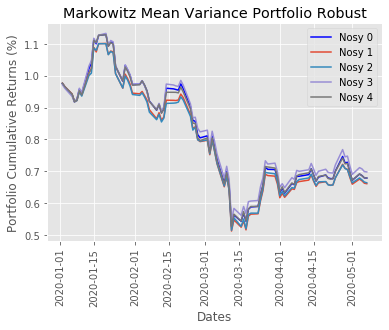

In [541]:
#All relatively close
markowitzRobust0 = cumulativeRet(w_Markowitz_robust_noisy[0],pricesValReturns)
markowitzRobust1 = cumulativeRet(w_Markowitz_robust_noisy[1],pricesValReturns)
markowitzRobust2 = cumulativeRet(w_Markowitz_robust_noisy[2],pricesValReturns)
markowitzRobust3 = cumulativeRet(w_Markowitz_robust_noisy[3],pricesValReturns)
markowitzRobust4 = cumulativeRet(w_Markowitz_robust_noisy[4],pricesValReturns)

dates = list(pricesVal.loc['2020-01-01':'2020-05-07'].index)

plt.xlabel("Dates")
plt.ylabel("Portfolio Cumulative Returns (%)")
plt.xticks(rotation=90)
plt.gca().ticklabel_format(useOffset=False, axis='both')

plt.plot(dates, list(markowitzRobust0),'b',label='Nosy 0')
plt.plot(dates, list(markowitzRobust1),label='Nosy 1')
plt.plot(dates, list(markowitzRobust2),label='Nosy 2')
plt.plot(dates, list(markowitzRobust3),label='Nosy 3')
plt.plot(dates, list(markowitzRobust4),label='Nosy 4')


plt.title("Markowitz Mean Variance Portfolio Robust")
plt.legend(loc='best')
plt.show()

In [648]:
N = len(Sigma_lb)
w = cp.Variable(N)
Lambda_ub = cp.Variable((N,N))
Lambda_lb = cp.Variable((N,N))



a = [[Lambda_ub - Lambda_lb,w],[w.T,1]]

cp.bmat(a)

# cp.bmat( [ [Lambda_ub - Lambda_lb, w] ,  [w.T,1] ] )

# cp.bmat( [ [Lambda_ub - Lambda_lb, w] ,  [w.T,1] ] ) == cp.Variable((N+1,N+1), PSD = True)

ValueError: All the input dimensions except for axis 1 must match exactly.

In [668]:
from scipy.sparse import coo_matrix, bmat
N = len(Sigma_lb)
w = cp.Variable(N)
Lambda_ub = cp.Variable((N,N))
Lambda_lb = cp.Variable((N,N))

a = cp.matrix([[Lambda_ub - Lambda_lb,w],[w.T,1]])
cp.bmat(a) #== cp.Variable((N+1,N+1), PSD = True)

AttributeError: module 'cvxpy' has no attribute 'matrix'

In [ ]:
MSRP_Ret = cumulativeRet(w_MSRP,pricesValReturns)
GMVP_Ret = cumulativeRet(w_GMVP,pricesValReturns)
MRP_Ret  = cumulativeRet(w_MRP, pricesValReturns)
CVaR_a095 = cumulativeRet(portfolioCVaR(pricesTrainingReturns,alpha = 0.95),pricesValReturns)
aveDD_c004 = cumulativeRet(portfolioAveDD(pricesTrainingReturns,pricesTrainingReturns,c = 0.04),pricesValReturns)
maxDD_c018 = cumulativeRet(portfolioMaxDD(pricesTrainingReturns,pricesTrainingReturns ,c = 0.18),pricesValReturns)
dr_alpha1 = cumulativeRet(portfolioDR(pricesTrainingReturns,alpha = 1),pricesValReturns)


In [736]:
# First bubble burst, 24/9/2018 - 17/12/2018
stocksBub =  ['GWPH','CRON.TO','WEED.TO','CRBP','TLRY','APHA.TO','ACB.TO','OGI.TO',
          'SWMA.ST','SMG','TPB','MEDIF','ARNA','JAPAY','CARA','UVV','IMBBY','PM','BTI','SWM',
          'XXII','MO','VGR','ZYNE','TGODF','SPRWF','CNPOF','CBWTF',
          'VLNCF','FLWPF','EMHTF']
pricesTrainingBubble1 = pdr.get_data_yahoo(stocksBub, start="2018-09-24", end="2018-12-17")[['Adj Close']]
pricesValBub = pdr.get_data_yahoo(stocksBub, start="2020-01-01", end="2020-05-15")[['Adj Close']]

In [737]:
pricesValBub = pricesValBub.interpolate(method = 'linear',limit_direction='forward')
pricesValBub = pricesValBub.interpolate(method = 'linear',limit_direction='backward')

pricesTrainingBubble1 = pricesTrainingBubble1.interpolate(method = 'linear',limit_direction='forward')
pricesTrainingBubble1 = pricesTrainingBubble1.interpolate(method = 'linear',limit_direction='backward')


In [738]:
pricesTrainingBubble1Returns = pricesTrainingBubble1.apply(np.log).apply(np.diff)
pricesValBubReturns = pricesValBub.apply(np.log).apply(np.diff)

In [739]:
trainCVMBub1 = np.cov(pricesTrainingBubble1Returns.T)
trainMuBub1  = np.mean(pricesTrainingBubble1Returns).to_numpy()

sigmaEstBub1 = sigma_est(trainCVMBub1,trainMuBub1)
meanEstBub1  = mu_est(trainCVMBub1,trainMuBub1)

sigmaBub1 = removeNeg(sigmaEstBub1)[0]
muBub1 = meanEstBub1[0]

In [741]:
muBub1

array([-0.0063451 , -0.00568925, -0.00680962, -0.005925  , -0.00651392,
       -0.0077979 , -0.00671484, -0.00644822, -0.00612872, -0.00603429,
       -0.00649852, -0.00686192, -0.00585836, -0.00567624, -0.00676703,
       -0.00574745, -0.00591175, -0.00559028, -0.00634166, -0.0065445 ,
       -0.00578984, -0.00595087, -0.00629421, -0.00714238, -0.00807891,
       -0.00675011, -0.00723691, -0.00676801, -0.00629205, -0.00666082,
       -0.00710401])

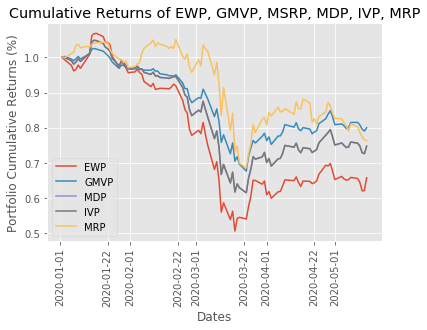

In [746]:
dates = list(pricesValBub.loc['2020-01-01':'2020-05-15'].index)

w_EWP = EWP(len(pricesTrainingBubble1Returns.columns))
w_GMVP = GMVP(sigmaBub1,muBub1)
# w_MSRP = MSRP(sigmaBub1,muBub1)
w_MDP = MSRP(sigmaBub1,np.sqrt(np.diag(sigmaBub1))) 
w_IVP = IVP(sigmaBub1)
w_MRP = MRP(muBub1)

EWP_Ret  = cumulativeRet(w_EWP, pricesValBubReturns)
GMVP_Ret = cumulativeRet(w_GMVP,pricesValBubReturns)
# MSRP_Ret = cumulativeRet(w_MSRP,pricesTrainingBubble1Returns)
MDP_Ret  = cumulativeRet(w_MDP, pricesValBubReturns)
IVP_Ret  = cumulativeRet(w_IVP, pricesValBubReturns)
MRP_Ret  = cumulativeRet(w_MRP, pricesValBubReturns)

plt.xlabel("Dates")
plt.ylabel("Portfolio Cumulative Returns (%)")
plt.xticks(rotation=90)
plt.gca().ticklabel_format(useOffset=False, axis='both')
plt.plot(dates, list(EWP_Ret),label='EWP')
plt.plot(dates, list(GMVP_Ret),label='GMVP')
# plt.plot(dates, list(MSRP_Ret),label='MSRP')
plt.plot(dates, list(MDP_Ret),label='MDP')
plt.plot(dates, list(IVP_Ret),label='IVP')
plt.plot(dates, list(MRP_Ret),label='MRP')
plt.title("Cumulative Returns of EWP, GMVP, MSRP, MDP, IVP, MRP")
plt.legend(loc='best')
plt.show()

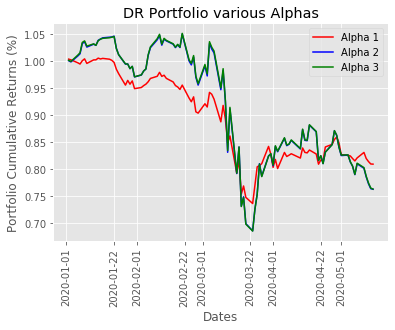

In [726]:
dr_alpha1 = cumulativeRet(portfolioDR(pricesTrainingBubble1Returns,alpha = 1),pricesValBubReturns)
dr_alpha2 = cumulativeRet(portfolioDR(pricesTrainingBubble1Returns,alpha = 2),pricesValBubReturns)
dr_alpha3 = cumulativeRet(portfolioDR(pricesTrainingBubble1Returns,alpha = 3),pricesValBubReturns)

dates = list(pricesValBub.loc['2020-01-01':'2020-05-15'].index)

plt.xlabel("Dates")
plt.ylabel("Portfolio Cumulative Returns (%)")
plt.xticks(rotation=90)
plt.gca().ticklabel_format(useOffset=False, axis='both')
plt.plot(dates, list(dr_alpha1),'r',label='Alpha 1')
plt.plot(dates, list(dr_alpha2),'b',label='Alpha 2')
plt.plot(dates, list(dr_alpha3),'g',label='Alpha 3')

plt.title("DR Portfolio various Alphas")
plt.legend(loc='best')

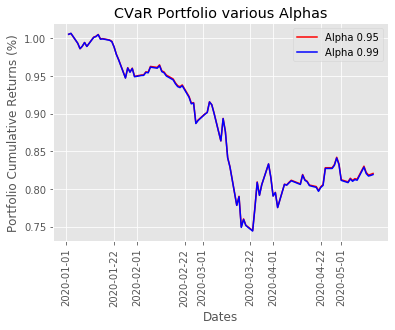

In [727]:
CVaR_a095 = cumulativeRet(portfolioCVaR(pricesTrainingBubble1Returns,alpha = 0.95),pricesValBubReturns)
CVaR_a099 = cumulativeRet(portfolioCVaR(pricesTrainingBubble1Returns,alpha = 0.99),pricesValBubReturns)
dates = list(pricesValBub.loc['2020-01-01':'2020-05-15'].index)

plt.xlabel("Dates")
plt.ylabel("Portfolio Cumulative Returns (%)")
plt.xticks(rotation=90)
plt.gca().ticklabel_format(useOffset=False, axis='both')
plt.plot(dates, list(CVaR_a095),'r',label='Alpha 0.95')
plt.plot(dates, list(CVaR_a099),'b',label='Alpha 0.99')


plt.title("CVaR Portfolio various Alphas")
plt.legend(loc='best')

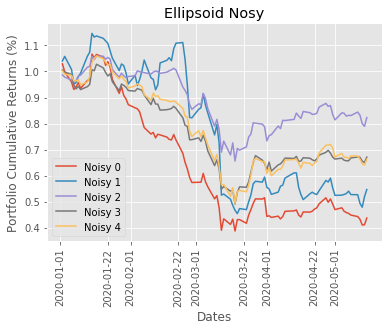

In [729]:
#Robust Data (Max Return, Markowitz)

# pricesTrainingBubble1 = pdr.get_data_yahoo(stocksBub, start="2018-09-24", end="2018-12-17")[['Adj Close']]

datesPre = list(pricesTrainingBubble1.loc['2018-09-24':'2018-12-17'].index)

w_GMRP_robust_ellipsoid_noisy = []


kappa = 0.2
for i in range(1,6):
    X_noisy = np.random.multivariate_normal(muBub1,sigmaBub1, size = len(datesPre))
    mu_noisy = np.mean(X_noisy, axis = 0)
    Sigma_noisy = np.cov(X_noisy.T)
    w_GMRP_robust_ellipsoid_noisy.append(portfolioMaxReturnRobustEllipsoid(mu_noisy, Sigma_noisy, kappa))

ellipsoidNosy0 = cumulativeRet(w_GMRP_robust_ellipsoid_noisy[0],pricesValBubReturns)
ellipsoidNosy1 = cumulativeRet(w_GMRP_robust_ellipsoid_noisy[1],pricesValBubReturns)
ellipsoidNosy2 = cumulativeRet(w_GMRP_robust_ellipsoid_noisy[2],pricesValBubReturns)
ellipsoidNosy3 = cumulativeRet(w_GMRP_robust_ellipsoid_noisy[3],pricesValBubReturns)
ellipsoidNosy4 = cumulativeRet(w_GMRP_robust_ellipsoid_noisy[4],pricesValBubReturns)

dates = list(pricesValBub.loc['2020-01-01':'2020-05-15'].index)

plt.xlabel("Dates")
plt.ylabel("Portfolio Cumulative Returns (%)")
plt.xticks(rotation=90)
plt.gca().ticklabel_format(useOffset=False, axis='both')

plt.plot(dates, list(ellipsoidNosy0),label='Noisy 0')
plt.plot(dates, list(ellipsoidNosy1),label='Noisy 1')
plt.plot(dates, list(ellipsoidNosy2),label='Noisy 2')
plt.plot(dates, list(ellipsoidNosy3),label='Noisy 3')
plt.plot(dates, list(ellipsoidNosy4),label='Noisy 4')


plt.title("Ellipsoid Nosy")
plt.legend(loc='best')
plt.show()

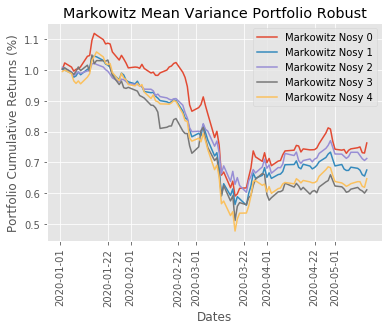

In [730]:
datesPre = list(pricesTrainingBubble1.loc['2018-09-24':'2018-12-17'].index)
kappa = 1 
T = len(dates)
delta = 0.1*(len(dates))

w_Markowitz_robust_noisy = []

for i in range(1,6):
    X_noisy = np.random.multivariate_normal(muBub1,sigmaBub1, size = len(datesPre))
    mu_noisy = np.mean(X_noisy, axis = 0)
    Sigma_noisy = np.cov(X_noisy.T)
    
    w_Markowitz_robust_noisy.append(portfolioMarkowitzRobust(mu_noisy, Sigma_noisy, kappa, delta/(T-1)**2 ))
    
markowitzRobust0 = cumulativeRet(w_Markowitz_robust_noisy[0],pricesValBubReturns)
markowitzRobust1 = cumulativeRet(w_Markowitz_robust_noisy[1],pricesValBubReturns)
markowitzRobust2 = cumulativeRet(w_Markowitz_robust_noisy[2],pricesValBubReturns)
markowitzRobust3 = cumulativeRet(w_Markowitz_robust_noisy[3],pricesValBubReturns)
markowitzRobust4 = cumulativeRet(w_Markowitz_robust_noisy[4],pricesValBubReturns)

dates = list(pricesValBub.loc['2020-01-01':'2020-05-15'].index)

plt.xlabel("Dates")
plt.ylabel("Portfolio Cumulative Returns (%)")
plt.xticks(rotation=90)
plt.gca().ticklabel_format(useOffset=False, axis='both')

plt.plot(dates, list(markowitzRobust0),label='Markowitz Nosy 0')
plt.plot(dates, list(markowitzRobust1),label='Markowitz Nosy 1')
plt.plot(dates, list(markowitzRobust2),label='Markowitz Nosy 2')
plt.plot(dates, list(markowitzRobust3),label='Markowitz Nosy 3')
plt.plot(dates, list(markowitzRobust4),label='Markowitz Nosy 4')


plt.title("Markowitz Mean Variance Portfolio Robust")
plt.legend(loc='best')
plt.show()

In [734]:
def portfolioAveDD(X, data ,c = 0.2):
    T = len(X)
    N = len(X.columns)
    mu = np.mean(X).to_numpy()
    X = X.to_numpy()
    
    dfCumsum = pd.DataFrame(columns = data.columns)
    for n in data.columns:
        dfCumsum[n] = data[n].cumsum()
    X_cum = dfCumsum.iloc[-1].to_numpy()

    #Variables
    w = cp.Variable(N)
    u = cp.Variable(T)
    
    prob = cp.Problem(cp.Maximize(w.T @ mu),
                     [w >= 0, sum(w) == 1,
                     np.mean(u) <= np.mean(X_cum @ w) + c,
                     u >= X_cum @ w,
#                      u[-1] >= u[-T]])
                     u[1:] >= u[:T-1]])
    prob.solve()
    return w.value
def portfolioMaxDD(X, data, c= 0.2):
    T = len(X)
    N = len(X.columns)
    mu = np.mean(X).to_numpy()
    X = X.to_numpy()
    
    dfCumsum = pd.DataFrame(columns = data.columns)
    for n in data.columns:
        dfCumsum[n] = data[n].cumsum()
    X_cum = dfCumsum.iloc[-1].to_numpy()

    #Variables
    w = cp.Variable(N)
    u = cp.Variable(T)
    
    #Problem
    
    prob = cp.Problem(cp.Maximize(w.T @ mu),
                     [w >= 0, sum(w) == 1,
                     u <= X_cum @ w + c,
                     u >= X_cum @ w,
                     #u[-1] >= u[-T]
                     u[1:] >= u[:T-1]])
    prob.solve()
    return w.value

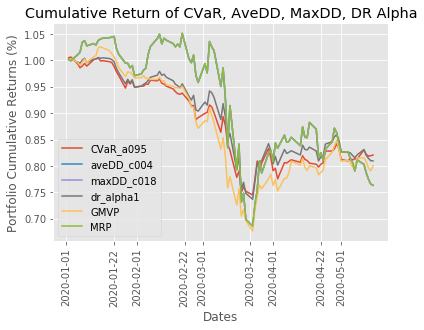

In [747]:
CVaR_a095 = cumulativeRet(portfolioCVaR(pricesTrainingBubble1Returns,alpha = 0.95),pricesValBubReturns)
aveDD_c004 = cumulativeRet(portfolioAveDD(pricesTrainingBubble1Returns,pricesTrainingBubble1Returns,c = 0.04),pricesValBubReturns)
maxDD_c018 = cumulativeRet(portfolioMaxDD(pricesTrainingBubble1Returns,pricesTrainingBubble1Returns ,c = 0.18),pricesValBubReturns)
dr_alpha1 = cumulativeRet(portfolioDR(pricesTrainingBubble1Returns,alpha = 1),pricesValBubReturns)

dates = list(pricesValBub.loc['2020-01-01':'2020-05-15'].index)

plt.xlabel("Dates")
plt.ylabel("Portfolio Cumulative Returns (%)")
plt.xticks(rotation=90)
plt.gca().ticklabel_format(useOffset=False, axis='both')
plt.plot(dates, list(CVaR_a095),label='CVaR_a095')
plt.plot(dates, list(aveDD_c004),label='aveDD_c004')
plt.plot(dates, list(maxDD_c018),label='maxDD_c018')
plt.plot(dates, list(dr_alpha1),label='dr_alpha1')
plt.plot(dates, list(GMVP_Ret),label='GMVP')
plt.plot(dates, list(MRP_Ret),label='MRP')




plt.title("Cumulative Return of CVaR, AveDD, MaxDD, DR Alpha")
plt.legend(loc='best')

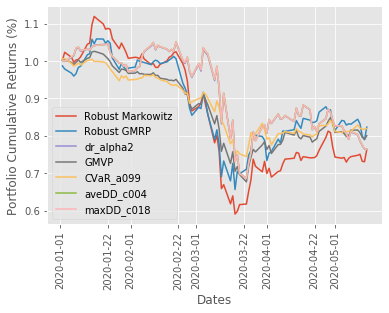

In [766]:
markowitzRobust0 = cumulativeRet(w_Markowitz_robust_noisy[0],pricesValBubReturns)
dr_alpha2 = cumulativeRet(portfolioDR(pricesTrainingBubble1Returns,alpha = 2),pricesValBubReturns)
ellipsoidNosy2 = cumulativeRet(w_GMRP_robust_ellipsoid_noisy[2],pricesValBubReturns)
CVaR_a099 = cumulativeRet(portfolioCVaR(pricesTrainingBubble1Returns,alpha = 0.99),pricesValBubReturns)
# MSRP_Ret = cumulativeRet(w_MSRP,pricesValReturns)
GMVP_Ret = cumulativeRet(w_GMVP,pricesValBubReturns)


plt.xlabel("Dates")
plt.ylabel("Portfolio Cumulative Returns (%)")
plt.xticks(rotation=90)
plt.gca().ticklabel_format(useOffset=False, axis='both')

plt.plot(dates, list(markowitzRobust0),label='Robust Markowitz')
plt.plot(dates, list(ellipsoidNosy2),label='Robust GMRP')
plt.plot(dates, list(dr_alpha2),label='dr_alpha2')
# plt.plot(dates, list(MSRP_Ret),label='MSRP')
plt.plot(dates, list(GMVP_Ret),label='GMVP')
plt.plot(dates, list(CVaR_a099),label='CVaR_a099')
plt.plot(dates, list(aveDD_c004),label='aveDD_c004')
plt.plot(dates, list(maxDD_c018),label='maxDD_c018')




# plt.title("Markowitz Mean Variance Portfolio Robust")
plt.legend(loc='best')
plt.show()

In [755]:
GMVP_Ret

0     1.001759
1     1.002957
2     0.995843
3     0.990440
4     0.996422
        ...   
91    0.815275
92    0.808126
93    0.796085
94    0.790531
95    0.800007
Length: 96, dtype: float64

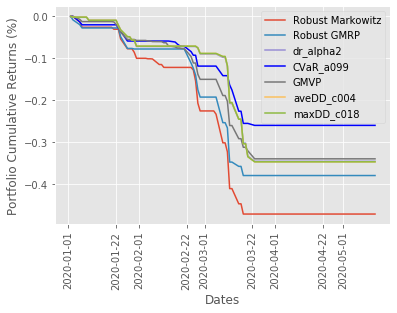

In [767]:

plt.xlabel("Dates")
plt.ylabel("Portfolio Cumulative Returns (%)")
plt.xticks(rotation=90)
plt.gca().ticklabel_format(useOffset=False, axis='both')

plt.plot(dates, list(drawdown(markowitzRobust0)),label='Robust Markowitz')
plt.plot(dates, list(drawdown(ellipsoidNosy2)),label='Robust GMRP')
plt.plot(dates, list(drawdown(dr_alpha2)),label='dr_alpha2')
plt.plot(dates, list(drawdown(CVaR_a099)),'b',label='CVaR_a099')
plt.plot(dates, list(drawdown(GMVP_Ret)),label='GMVP')
plt.plot(dates, list(drawdown(aveDD_c004)),label='aveDD_c004')
plt.plot(dates, list(drawdown(maxDD_c018)),label='maxDD_c018')




# plt.title("Markowitz Mean Variance Portfolio Robust")
plt.legend(loc='best')
plt.show()

In [773]:
maxDD_c018

0     1.001175
1     0.999292
2     1.010860
3     1.015316
4     1.034407
        ...   
91    0.803078
92    0.787033
93    0.774772
94    0.765367
95    0.763337
Length: 96, dtype: float64

In [770]:
drawdown(CVaR_a095)

0     0.000000
1     0.000000
2    -0.013020
3    -0.020174
4    -0.020174
        ...   
91   -0.259793
92   -0.259793
93   -0.259793
94   -0.259793
95   -0.259793
Length: 96, dtype: float64

In [764]:
drawdown(maxDD_c018)

0     0.000000
1    -0.001880
2    -0.001880
3    -0.001880
4    -0.001880
        ...   
91   -0.347476
92   -0.347476
93   -0.347476
94   -0.347476
95   -0.347476
Length: 96, dtype: float64